In [1]:
import os
import numpy as np
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et
from scipy.interpolate import griddata
import rasterio
from rasterio.enums import Resampling
import matplotlib.pylab as plt
import pandas as pd

In [2]:
# # Get data and set working directory
project_dir = "/Users/octavia/Dropbox/fire/"

	0 - Rock and water
	1 - Conifer-dominated
	2 - Shrub-dominated
	3 - Sparse meadow
	4 - Dense meadow
	5 - Aspen

In [3]:
df_soil = pd.read_csv('/Users/octavia/Dropbox/fire/fire_data/RF_soil_regrid/vwcJun12utm11.csv', 
                 sep = " ", header = None)
df_soil.columns = ["x", "y", "z"]


In [4]:
ls /Users/octavia/Dropbox/fire/fire_data/Veg_regrid/

veg12_30m_icb.csv          veg69_30m_icb.csv
veg12_30m_icb.tif          veg69_30m_icb.tif
veg12_30m_icb.tif.aux.xml  veg69_30m_icb.tif.aux.xml


In [5]:
def load_csv(path):
    df = pd.read_csv(path, sep = " ", header = None)
    df.columns = ["x", "y", "z"]
    return df

In [6]:
veg69= load_csv("/Users/octavia/Dropbox/fire/fire_data/Veg_regrid/veg69_30m_icb.csv")

In [7]:
veg12 = load_csv("/Users/octavia/Dropbox/fire/fire_data/Veg_regrid/veg12_30m_icb.csv")

In [8]:
soil12 = load_csv('/Users/octavia/Dropbox/fire/fire_data/RF_soil_regrid/vwcJun12utm11.csv')

In [9]:
def scatter(df, ax, cmap):
    subset = df.copy()
    subset = subset[subset.z >= 0]
    ax.scatter(subset.x, subset.y,c = subset.z, cmap = cmap)
    return ax

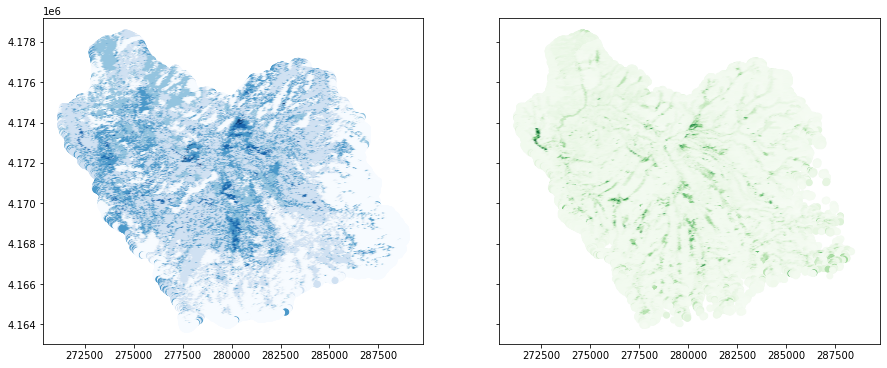

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)

scatter(veg12, axes[0], cmap = "Blues")
scatter(soil12, axes[1], cmap = "Greens")


In [11]:
x = np.arange(max(soil12.x.min(), veg69.x.min()), min(soil12.x.max(), veg69.x.max()), 30)
y = np.arange(max(soil12.y.min(), veg69.y.min()), min(soil12.y.max(), veg69.y.max()), 30)
grid_x, grid_y = np.meshgrid(x,y)

In [12]:
def grid_points(df, grid_x, grid_y):
    """
    pandas dataframe x,y,z points --> gridded points and vals
    """
    grid_points = np.array((list(df.x.ravel()), list(df.y.ravel()))).T
    grid_vals= np.array(df.z)
    grid_vals = grid_vals.astype("float")

    gridded = griddata(grid_points, grid_vals, (grid_x, grid_y), method='nearest')    
    gridded[gridded < 0] = np.nan
#     return grid_points, gridded_vals
    return gridded

In [13]:
gridded_soil = grid_points(soil12, grid_x, grid_y)

In [14]:
gridded_veg12 = grid_points(veg12,grid_x, grid_y)

In [15]:
gridded_veg69 = grid_points(veg69, grid_x, grid_y)

In [16]:
gridded_veg12

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

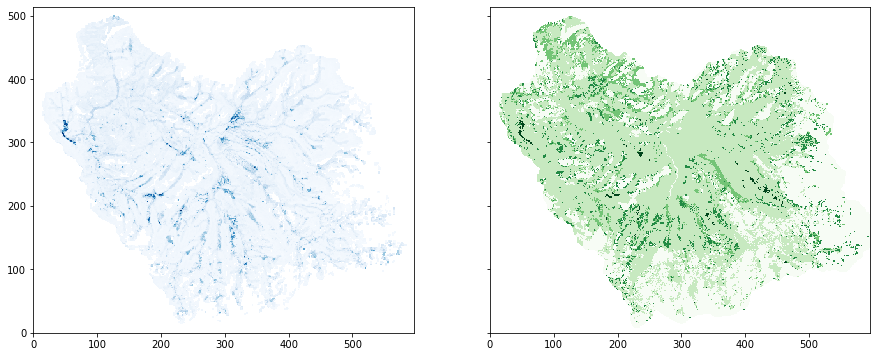

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)


axes[0].pcolormesh(gridded_soil, cmap = "Blues")
axes[1].pcolormesh(gridded_veg69, cmap = "Greens")


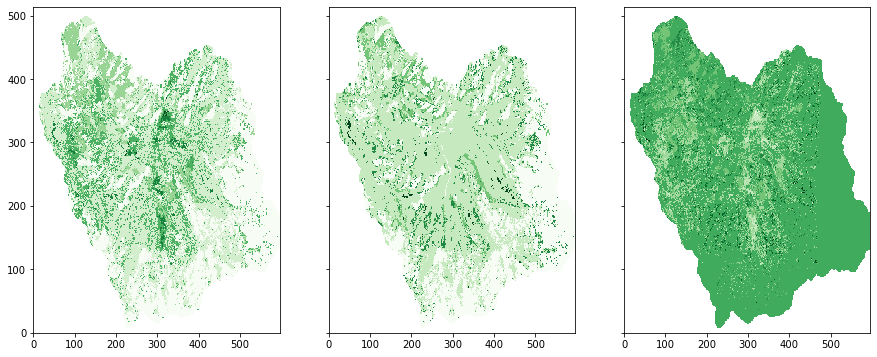

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (15, 6), sharey = True, sharex = True)


axes[0].pcolormesh(gridded_veg12, cmap = "Greens")
axes[1].pcolormesh(gridded_veg69, cmap = "Greens")
axes[2].pcolormesh(gridded_veg69-gridded_veg12, cmap = "Greens")


# work out transition matrices

In [19]:
trees_and_shrubs = np.sum((gridded_veg69 == 1) | (gridded_veg69 == 2))

tree_to_tree = np.sum((gridded_veg12 == 1) & (gridded_veg69 == 1))
tree_to_shrub = np.sum((gridded_veg12 == 2) & (gridded_veg69 == 1))
shrub_to_shrub = np.sum((gridded_veg12 == 2) & (gridded_veg69 == 2))
shrub_to_tree = np.sum((gridded_veg12 == 1) & (gridded_veg69 == 2))

In [20]:
trees_and_shrubs = np.sum((gridded_veg69 == 1) | (gridded_veg69 == 2))

tree_to_tree = np.sum((gridded_veg12 == 1) & (gridded_veg69 == 1))
tree_to_shrub = np.sum((gridded_veg12 == 2) & (gridded_veg69 == 1))
shrub_to_shrub = np.sum((gridded_veg12 == 2) & (gridded_veg69 == 2))
shrub_to_tree = np.sum((gridded_veg12 == 1) & (gridded_veg69 == 2))

In [21]:
np.sum((gridded_veg12 == 1) & (gridded_veg69 == 3))/np.sum(gridded_veg69 == 3)

0.36143110323438193

### Vegetation categories

    0 - Rock and water
    1 - Conifer-dominated
    2 - Shrub-dominated
    3 - Sparse meadow
    4 - Dense meadow
    5 - Aspen

In [22]:
transition_two_way = np.zeros([2,2], dtype = int)

transition_two_way[0,0] = np.sum((gridded_veg12 == 1) & (gridded_veg69 == 1))

shrub_to_tree = np.sum((gridded_veg12 == 1) & 
                                 ((gridded_veg69 == 2) | (gridded_veg69 == 3)) )    
transition_two_way[1,0]  = shrub_to_tree

tree_to_shrub = np.sum((gridded_veg69 == 1) & 
                                 ((gridded_veg12 == 2) | (gridded_veg12 == 3)) )    
transition_two_way[0,1] = tree_to_shrub

shrub_to_shrub = np.sum( ((gridded_veg69 == 2) | (gridded_veg69 == 3)) &
                                 ((gridded_veg12 == 2) | (gridded_veg12 == 3)) )    
transition_two_way[1,1] = shrub_to_shrub

to_rock  = np.sum( (gridded_veg69 != 0) & (gridded_veg12 == 0))
from_rock  = np.sum( (gridded_veg69 == 0) & (gridded_veg12 != 0))

names = np.array(["conifer", "shrub"])
index = np.array([n + "_69" for n in names])
cols = np.array([n + "_12" for n in names])


pd.DataFrame(transition_two_way, columns = cols, index = index).round(1)


,conifer_12,shrub_12
conifer_69,62763,29286
shrub_69,7379,12345


In [23]:
two_way_fraction = np.zeros([2,2], dtype = float)


two_way_fraction[0,0] = transition_two_way[0,0]/ np.sum(gridded_veg69 == 1)

two_way_fraction[1,0] = transition_two_way[1,0]/ np.sum(
                                 (gridded_veg69 == 2) | (gridded_veg69 == 3))    


two_way_fraction[0,1] = transition_two_way[0, 1] /  np.sum(gridded_veg69 == 1)


two_way_fraction[1,1] = transition_two_way[1,1]/ np.sum(
                                 (gridded_veg69 == 2) | (gridded_veg69 == 3))    



names = np.array(["conifer", "shrub"])
index = np.array([n + "_69" for n in names])
cols = np.array([n + "_12" for n in names])


pd.DataFrame(two_way_fraction, columns = cols, index = index)#.round(2)


,conifer_12,shrub_12
conifer_69,0.662525,0.309143
shrub_69,0.365134,0.610866


In [24]:
 total69 = np.sum( (gridded_veg69 == 1) |(gridded_veg69 == 2) | (gridded_veg69 == 3))

In [25]:
two_way_fraction = np.zeros([2,2], dtype = float)


two_way_fraction[0,0] = transition_two_way[0,0]/ total69

two_way_fraction[1,0] = transition_two_way[1,0]/ total69


two_way_fraction[0,1] = transition_two_way[0, 1] /  total69


two_way_fraction[1,1] = transition_two_way[1,1]/ total69   



names = np.array(["conifer", "shrub"])
index = np.array([n + "_69" for n in names])
cols = np.array([n + "_12" for n in names])


pd.DataFrame(two_way_fraction, columns = cols, index = index)#.round(2)


,conifer_12,shrub_12
conifer_69,0.546041,0.254789
shrub_69,0.064198,0.107402


In [26]:
total = np.sum((gridded_veg69 == 1) | (gridded_veg69 == 2) | (gridded_veg69 == 3)) 

initial_tree = np.sum((gridded_veg69 == 1) ) / total

total = np.sum((gridded_veg69 == 1) | (gridded_veg69 == 2) | (gridded_veg69 == 3))  


total = np.sum((gridded_veg12 == 1) | (gridded_veg12 == 2) | (gridded_veg12  == 3)) 


final_tree = np.sum((gridded_veg12 == 1) ) / total

final_shrub = np.sum((gridded_veg12 == 2) | (gridded_veg12 == 3) ) / total

In [27]:
initial_tree, final_tree, 1- final_shrub


(0.8241808912320997, 0.6278790849959293, 0.6278790849959293)

# Four way transitions

In [28]:
transition = np.zeros([5,5], dtype = int)
for i in range(5):
    for j in range(5):
        transition[i, j] = np.sum((gridded_veg12 == j) & (gridded_veg69 == i))
transition = transition[1:, 1:]        


In [29]:
full_transition = transition/transition.sum()*100
full_transition.astype(int)

names = np.array(["conifer", "shrub", "grass", "wetland"])
index = np.array([n + "_69" for n in names])
cols = np.array([n + "_12" for n in names])
full_transition = pd.DataFrame(full_transition, columns=cols, index = index).round(1)
transition_df = pd.DataFrame(transition, columns=cols, index = index).round(1)

In [30]:
transition_df


,conifer_12,shrub_12,grass_12,wetland_12
conifer_69,62763,9548,19738,1860
shrub_69,4116,4607,2203,14
grass_69,3263,663,4872,29
wetland_69,344,12,21,330


In [31]:
df = pd.DataFrame(transition, columns=cols, index = index)
(df.T/df.T.sum(0)).round(2).T*100

,conifer_12,shrub_12,grass_12,wetland_12
conifer_69,67.0,10.0,21.0,2.0
shrub_69,38.0,42.0,20.0,0.0
grass_69,37.0,8.0,55.0,0.0
wetland_69,49.0,2.0,3.0,47.0


### Consider tree - shrub transitions

In [32]:
# Mini transition matrix
df_mini = pd.DataFrame(transition[:2, :2], columns=cols[:2], index = index[:2])
# (df_mini.T/df_mini.T.sum(0)).round(2).T*100
df_mini

,conifer_12,shrub_12
conifer_69,62763,9548
shrub_69,4116,4607


In [33]:
initial_veg = df_mini.sum(1)/np.sum(np.array(df_mini))
print ("initial conifer fraction = {0:.2f}".format(
   initial_veg[0]))
        
print ("initial shrub fraction = {0:.2f}".format(
    initial_veg[1]))

final_veg = df_mini.sum(0)/np.sum(np.array(df_mini))
print ("final conifer fraction = {0:.2f}".format(
   final_veg[0]))
        
print ("final shrub fraction = {0:.2f}".format(
    final_veg[1]))

initial conifer fraction = 0.89
initial shrub fraction = 0.11
final conifer fraction = 0.83
final shrub fraction = 0.17


### Consider tree - grass transitions

In [34]:
# Mini transition matrix
sub= [0,2]
df_mini = pd.DataFrame( np.vstack((transition[0], transition[2]))[:, [0, 2]],                       
                       columns=[cols[i] for i in sub], 
                       index = [index[i] for i in sub])
# (df_mini.T/df_mini.T.sum(0)).round(2).T*100
df_mini

,conifer_12,grass_12
conifer_69,62763,19738
grass_69,3263,4872


In [35]:
initial_veg = df_mini.sum(1)/np.sum(np.array(df_mini))
print ("initial conifer fraction = {0:.2f}".format(
   initial_veg[0]))
        
print ("initial grass fraction = {0:.2f}".format(
    initial_veg[1]))

final_veg = df_mini.sum(0)/np.sum(np.array(df_mini))
print ("final conifer fraction = {0:.2f}".format(
   final_veg[0]))
        
print ("final grass fraction = {0:.2f}".format(
    final_veg[1]))

initial conifer fraction = 0.91
initial grass fraction = 0.09
final conifer fraction = 0.73
final grass fraction = 0.27


### Consider tree - wetland transitions

In [36]:
# Mini transition matrix
sub= [0,3]
df_mini = pd.DataFrame( np.vstack((transition[0], transition[3]))[:, [0, 3]],                       
                       columns=[cols[i] for i in sub], 
                       index = [index[i] for i in sub])
# (df_mini.T/df_mini.T.sum(0)).round(3).T*100
df_mini

,conifer_12,wetland_12
conifer_69,62763,1860
wetland_69,344,330


In [37]:

initial_veg = df_mini.sum(1)/np.sum(np.array(df_mini))
print ("initial conifer fraction = {0:.2f}".format(
   initial_veg[0]))
        
print ("initial wetland fraction = {0:.2f}".format(
    initial_veg[1]))

final_veg = df_mini.sum(0)/np.sum(np.array(df_mini))
print ("final conifer fraction = {0:.2f}".format(
   final_veg[0]))
        
print ("final wetland fraction = {0:.2f}".format(
    final_veg[1]))

initial conifer fraction = 0.99
initial wetland fraction = 0.01
final conifer fraction = 0.97
final wetland fraction = 0.03


## Saving IC files

Text(0.5, 1.0, '2012 soil moisture by 1969 vegetation type')

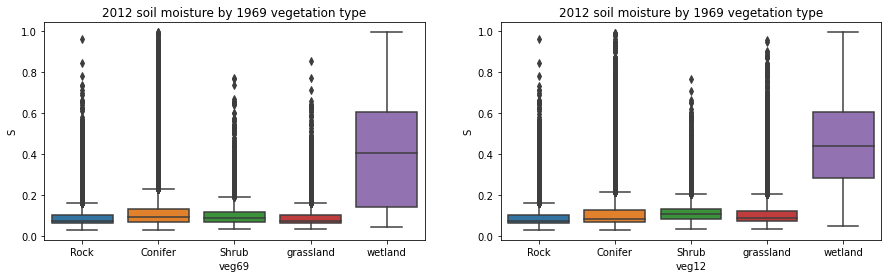

In [38]:
zipped = np.array(( 
        list(grid_x.ravel()), 
        list(grid_y.ravel()),
        list(gridded_veg69.ravel()), 
        list(gridded_veg12.ravel()),     
        list(gridded_soil.ravel())))
inds = np.where((np.isnan(zipped[0] ) ==0) & (np.isnan(zipped[1] ) ==0))

import seaborn as sns

df = pd.DataFrame(zipped.T[inds], columns=["x", "y", "veg69","veg12","soil_moisture"])
df["S"] = df["soil_moisture"]/0.4/100.
df = df[df["S"] < 1]

df = df[df.veg12 != 5]

figure, axes = plt.subplots(1,2, figsize = (15,4))

ax = sns.boxplot(x="veg69", y="S", data=df, ax= axes[0])

xlabels = ["Rock", "Conifer", "Shrub", "grassland", "wetland"]

ax.set_xticklabels(xlabels )
ax.set_title("2012 soil moisture by 1969 vegetation type")


ax = sns.boxplot(x="veg12", y="S", data=df, ax= axes[1])



ax.set_xticklabels(xlabels )
ax.set_title("2012 soil moisture by 1969 vegetation type")

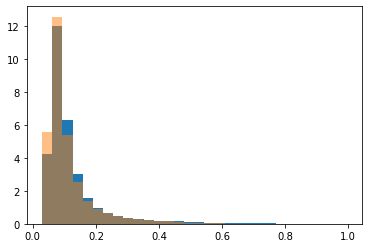

In [39]:
df = df.dropna(axis = 0)
plt.hist(df[df.veg69 == 1]["S"], 30, density=1);

# len(df[df.veg == 2]["theta"])
plt.hist(df[df.veg12 == 1]["S"], 30, density = 1, alpha = 0.5);


In [40]:
IC = df[
    ((df.veg69>0)& (df.veg69<4))
    & ((df.veg12>0)& (df.veg12<4))
    ][["veg69", "veg12", "S"]]

In [41]:
model_dir = "/Users/octavia/Dropbox/fire/fire_model/"

IC_csv = os.path.join(model_dir, "IC.csv")
IC.sample(1000).to_csv(IC_csv, index = False)

In [42]:
np.random.seed(0)
sampled = IC.sample(1000)
len(sampled[sampled.veg69 == 1]), len(sampled[sampled.veg69 == 2]) 
shrub_count69 =  len(sampled[ (sampled.veg69 == 2) | (sampled.veg69 == 3)])
tree_count69 =  len(sampled[sampled.veg69 == 1])                 
total69 = shrub_count69+ tree_count69

shrub_count12 =  len(sampled[(sampled.veg12 == 2) | (sampled.veg12 == 3)])
tree_count12 =  len(sampled[sampled.veg12 == 1])  

total12 = shrub_count12  + tree_count12
print (shrub_count69/total69, shrub_count12/total12)
print (tree_count69/total69, tree_count12/total12)


0.167 0.362
0.833 0.638


In [43]:
ICarray = np.array(pd.read_csv(IC_csv))

In [44]:
severity_dir = "/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip"


In [45]:
csvs = [f for f in os.listdir(severity_dir) if "csv" in f]
RdNBR = []

x_min = np.inf
x_max = 0

y_min = np.inf
y_max = 0

for csv in csvs:
    path = os.path.join(severity_dir, csv)

    dum = np.array(pd.read_csv(path, sep = " ", header = None)[2])

    x = np.array(pd.read_csv(path, sep = " ", header = None)[0])
    x_min = min(np.min(x), x_min)
    x_max = max(np.max(x), x_max)  
    
    y = np.array(pd.read_csv(path, sep = " ", header = None)[1])
    y_min = min(np.min(y), y_min)
    y_max = max(np.max(y), y_max)      

    dum = dum[dum < 2000] 
    dum[dum > 693] = 693  # see Miller 2006 "Quantifying burn severity ...""

    dum = list(dum[dum > 69] )    
    print(path, len(dum))
    RdNBR.append(dum)

RdNBR = [s for slist in RdNBR for s in slist]


/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/1974BurnSev.csv 11383
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1991.csv 9337
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1986.csv 17360
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1978.csv 5190
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1996.csv 11257
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1980.csv 5190
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1994.csv 11257
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1981.csv 7612
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1999.csv 0
/Users/octavia/Dropbox/fire/fire_data/data from katya/BurnSeverityClip/BurnSeverityClip1988.csv 601

In [46]:
dum = np.isnan(gridded_veg69) == 0
area = np.sum((gridded_veg69[dum] >0) & (gridded_veg69[dum] <5))
# area = np.sum(np.isnan(gridded_veg12) == 0)

In [47]:
area

115651

In [48]:
timespan = 2004-1974

In [49]:
timespan

30

In [50]:
RI = 1/(len(RdNBR)/area/timespan)
print ("RI = " , RI)

RI =  26.403936013150485


Text(0.5, 1.0, 'Severity')

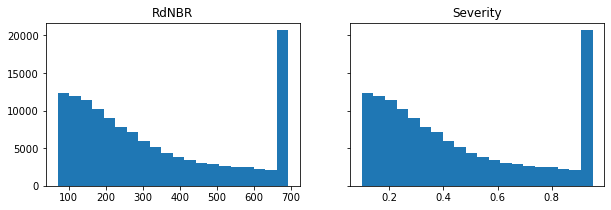

In [51]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3), sharey = True, sharex = False)


axes[0].hist(RdNBR, 20);
axes[0].set_title("RdNBR")

minval = np.percentile(RdNBR, 0)
maxval = np.percentile(RdNBR, 99)
severities = (np.array(RdNBR) - minval  )/(maxval - minval) 
severities = severities*(0.95-0.1) + 0.1
axes[1].hist(severities, 20);
axes[1].set_title("Severity")

In [57]:
severities.mean()

0.4599372533132797

In [53]:
model_dir ="/Users/octavia/Dropbox/fire/fire_model/"
severity_csv = os.path.join(model_dir, "severity.csv")

np.savetxt(severity_csv, severities)

In [54]:
severity_dir =os.path.join(model_dir, "severity.csv")
severities = np.loadtxt(severity_dir)

In [55]:
[{'veg' : ICarray[i, 0], 'S' : np.round(ICarray[i, 1],3)} for i in range(len(ICarray))];

In [56]:
severities = np.tile(severities, (2,1)).T
np.random.shuffle(severities[:, 1])